## Data
Parking data from https://www.kaggle.com/datasets/lsiddiqsunny/parking-birmingham-data-set

Weather data from https://data.ceda.ac.uk/badc/ukmo-midas-open/data/uk-hourly-weather-obs/dataset-version-202107/west-midlands/56424_winterbourne-no2/qc-version-1

## Imports

In [3]:
import pandas as pd
import numpy as np
import torch
import sklearn
from sklearn import preprocessing
import datetime
import time
import re
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

## Loading the parking dataset

Load parking dataset from csv, calculate occupancy rate of each entry

In [109]:
df = pd.read_csv("parking_dataset.csv")

df["OccupancyRate"] = df["Occupancy"] / df["Capacity"] 
le = preprocessing.LabelEncoder()
strings_list = ["SystemCodeNumber"]
df_numeric = df.copy()
df_numeric[strings_list] = df_numeric[strings_list].apply(le.fit_transform)
df = df_numeric

Calculate day of week for each day, add as new column
Calculate time since midnight, add as new column

In [110]:
df["DayOfWeek"] = df["LastUpdated"].apply(lambda x: pd.to_datetime(x).weekday())
df["TimeOfDay"] = df["LastUpdated"].apply(lambda x: (pd.to_datetime(x) - pd.to_datetime(x).replace(hour=0, minute=0, second=0)).total_seconds())

Load weather dataset, use binary search to match each parking data entry with closest respective weather observations

In [111]:
weather = pd.read_csv("hourly_weather.csv", header=280)

def get_closest_weather(time_str, column):
    df_time = pd.to_datetime(time_str)
    low, high = 0, len(weather)
    best_find = 0
    while(low <= high):
        middle = low + (high - low) // 2
        data_middle = pd.to_datetime(weather.iloc[middle]["ob_time"])
        if (data_middle - df_time).total_seconds() < 0:
                low = middle + 1
        elif (data_middle - df_time).total_seconds() > 0:
            high = middle - 1
        else:
            best_find = middle
            break
        if abs((data_middle - df_time).total_seconds()) < abs((pd.to_datetime(weather.iloc[best_find]["ob_time"]) - df_time).total_seconds()):
            best_find = middle
    return weather.iloc[best_find][column]

df["Temperature"] = df["LastUpdated"].apply(lambda x: get_closest_weather(x, "air_temperature"))
df["Sun_time"] = df["LastUpdated"].apply(lambda x: get_closest_weather(x, "drv_hr_sun_dur"))
df

,SystemCodeNumber,Capacity,Occupancy,LastUpdated,OccupancyRate,DayOfWeek,TimeOfDay,Temperature,Sun_time
0,0,577,61,2016-10-04 07:59:42,0.105719,1,28782.0,10.8,0.0
1,0,577,64,2016-10-04 08:25:42,0.110919,1,30342.0,10.8,0.0
2,0,577,80,2016-10-04 08:59:42,0.138648,1,32382.0,12.7,0.1
3,0,577,107,2016-10-04 09:32:46,0.185442,1,34366.0,14.9,0.3
4,0,577,150,2016-10-04 09:59:48,0.259965,1,35988.0,14.9,0.3
...,...,...,...,...,...,...,...,...,...
35712,29,1920,1517,2016-12-19 14:30:33,0.790104,0,52233.0,7.2,0.0
35713,29,1920,1487,2016-12-19 15:03:34,0.774479,0,54214.0,7.2,0.0
35714,29,1920,1432,2016-12-19 15:29:33,0.745833,0,55773.0,7.2,0.0
35715,29,1920,1321,2016-12-19 16:03:35,0.688021,0,57815.0,7.1,0.0


In [137]:
df = df.drop("LastUpdated", axis=1)

df_new=df.loc[:,df.columns!='OccupancyRate']
df_new['OccupancyRate']=df['OccupancyRate']
df=df_new

df = df.drop(["Capacity", "Occupancy"], axis=1)
df

,SystemCodeNumber,DayOfWeek,TimeOfDay,Temperature,Sun_time,OccupancyRate
0,0,1,28782.0,10.8,0.0,0.105719
1,0,1,30342.0,10.8,0.0,0.110919
2,0,1,32382.0,12.7,0.1,0.138648
3,0,1,34366.0,14.9,0.3,0.185442
4,0,1,35988.0,14.9,0.3,0.259965
...,...,...,...,...,...,...
35712,29,0,52233.0,7.2,0.0,0.790104
35713,29,0,54214.0,7.2,0.0,0.774479
35714,29,0,55773.0,7.2,0.0,0.745833
35715,29,0,57815.0,7.1,0.0,0.688021


In [138]:
df = df.fillna(value=0)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1:])
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

<Axes: >

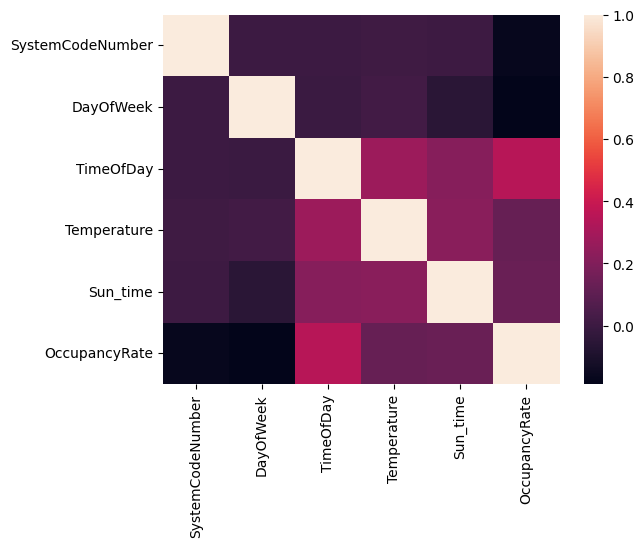

In [114]:
sns.heatmap(df.corr())

<Axes: xlabel='SystemCodeNumber', ylabel='count'>

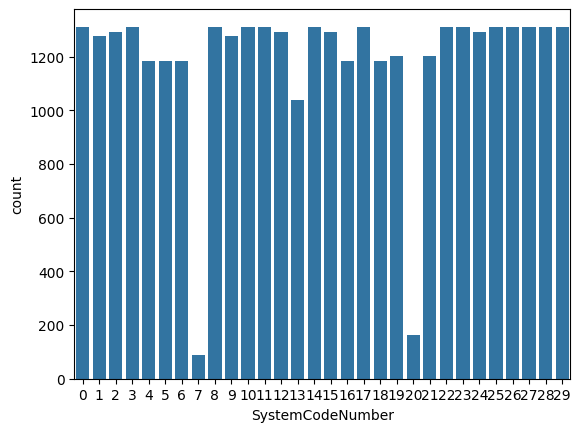

In [115]:
sns.countplot(df, x="SystemCodeNumber")

In [142]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

array([0.56030151, 0.15968676, 0.88833333, ..., 0.29555556, 0.25808648,
       0.19003476])

## Neural Network

In [79]:
hidden_layer_list = []

for x in range(10,110,10):
    for y in range(1,11):
        hls = []
        base_value = x // y
        
        # Calculate the remainder after evenly distributing the base value
        remainder = x % y
        
        # Append base value to the list for the first (target_sum % num_numbers) numbers
        for i in range(remainder):
            hls.append(base_value + 1)
        
        # Append base value to the list for the rest of the numbers
        for i in range(remainder, y):
            hls.append(base_value)

        hidden_layer_list.append(tuple(hls))

[(10,),
 (5, 5),
 (4, 3, 3),
 (3, 3, 2, 2),
 (2, 2, 2, 2, 2),
 (2, 2, 2, 2, 1, 1),
 (2, 2, 2, 1, 1, 1, 1),
 (2, 2, 1, 1, 1, 1, 1, 1),
 (2, 1, 1, 1, 1, 1, 1, 1, 1),
 (1, 1, 1, 1, 1, 1, 1, 1, 1, 1),
 (20,),
 (10, 10),
 (7, 7, 6),
 (5, 5, 5, 5),
 (4, 4, 4, 4, 4),
 (4, 4, 3, 3, 3, 3),
 (3, 3, 3, 3, 3, 3, 2),
 (3, 3, 3, 3, 2, 2, 2, 2),
 (3, 3, 2, 2, 2, 2, 2, 2, 2),
 (2, 2, 2, 2, 2, 2, 2, 2, 2, 2),
 (30,),
 (15, 15),
 (10, 10, 10),
 (8, 8, 7, 7),
 (6, 6, 6, 6, 6),
 (5, 5, 5, 5, 5, 5),
 (5, 5, 4, 4, 4, 4, 4),
 (4, 4, 4, 4, 4, 4, 3, 3),
 (4, 4, 4, 3, 3, 3, 3, 3, 3),
 (3, 3, 3, 3, 3, 3, 3, 3, 3, 3),
 (40,),
 (20, 20),
 (14, 13, 13),
 (10, 10, 10, 10),
 (8, 8, 8, 8, 8),
 (7, 7, 7, 7, 6, 6),
 (6, 6, 6, 6, 6, 5, 5),
 (5, 5, 5, 5, 5, 5, 5, 5),
 (5, 5, 5, 5, 4, 4, 4, 4, 4),
 (4, 4, 4, 4, 4, 4, 4, 4, 4, 4),
 (50,),
 (25, 25),
 (17, 17, 16),
 (13, 13, 12, 12),
 (10, 10, 10, 10, 10),
 (9, 9, 8, 8, 8, 8),
 (8, 7, 7, 7, 7, 7, 7),
 (7, 7, 6, 6, 6, 6, 6, 6),
 (6, 6, 6, 6, 6, 5, 5, 5, 5),
 (5, 5, 5, 5, 5, 5

Preform grid search on hidden layer combinations

In [80]:
model_grid = MLPRegressor(alpha=0.0001, max_iter=300, learning_rate="constant")
hyper_parameters = {
    'hidden_layer_sizes': hidden_layer_list
}
gscv = GridSearchCV(model_grid, hyper_parameters, verbose=2, scoring="neg_mean_squared_error")
start_time = time.time()
print("starting")
gscv.fit(X_train_scaled, y_train)
print("done")
end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print("Elapsed time:", elapsed_time, "seconds")
best_params = gscv.best_params_

print(best_params)

starting
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ...........................hidden_layer_sizes=(10,); total time=   0.3s
[CV] END ...........................hidden_layer_sizes=(10,); total time=   0.4s
[CV] END ...........................hidden_layer_sizes=(10,); total time=   0.5s
[CV] END ...........................hidden_layer_sizes=(10,); total time=   0.5s
[CV] END ...........................hidden_layer_sizes=(10,); total time=   0.6s
[CV] END ..........................hidden_layer_sizes=(5, 5); total time=   0.5s
[CV] END ..........................hidden_layer_sizes=(5, 5); total time=   0.8s
[CV] END ..........................hidden_layer_sizes=(5, 5); total time=   0.7s
[CV] END ..........................hidden_layer_sizes=(5, 5); total time=   0.4s
[CV] END ..........................hidden_layer_sizes=(5, 5); total time=   0.5s
[CV] END .......................hidden_layer_sizes=(4, 3, 3); total time=   0.7s
[CV] END .......................hidde

Heatmap of MSE results from grid search

Text(0.5, 1.0, 'Negative MSE values from grid search')

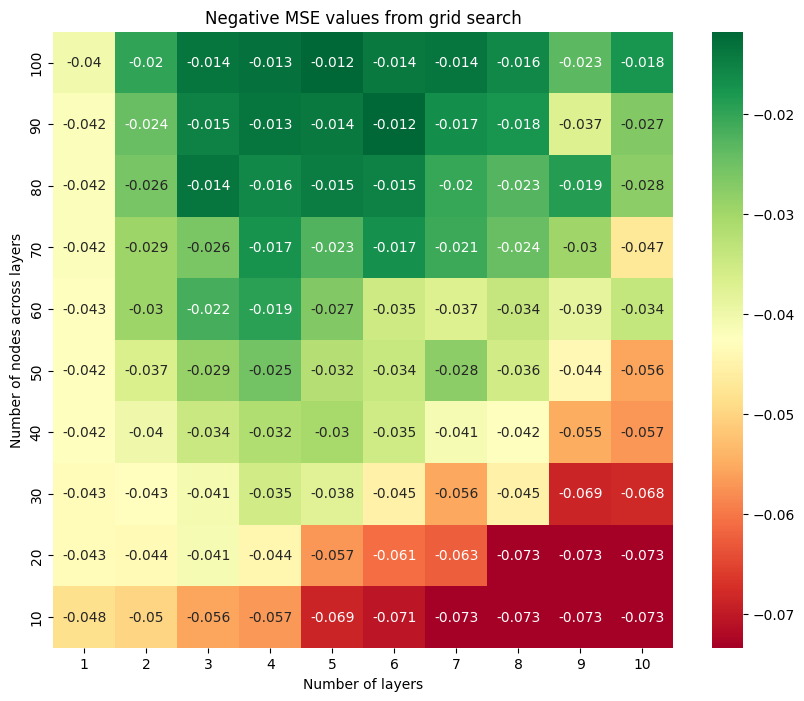

In [84]:
scores = gscv.cv_results_['mean_test_score'].reshape(10, 10)
scores = np.flip(scores, axis=0)
plt.figure(figsize=(10, 8))
sns.heatmap(scores, annot=True, cmap='RdYlGn',  xticklabels=range(1,11), yticklabels=range(100,0,-10))
plt.xlabel("Number of layers")
plt.ylabel("Number of nodes across layers")
plt.title("Negative MSE values from grid search")

Find best learning rate

In [85]:
alphas = [0.01, 0.001, 0.0001, 0.00001]
loss_curves = []
for a in alphas:
    mlp_lr_test = MLPRegressor(hidden_layer_sizes=(15, 15, 15, 15, 15, 15), alpha=a, max_iter=200, learning_rate="constant")
    mlp_lr_test.fit(X_train_scaled, y_train)
    loss_curves.append((a, mlp_lr_test.loss_curve_))
    print(f"done with {a}")

done with 0.01
done with 0.001
done with 0.0001
done with 1e-05


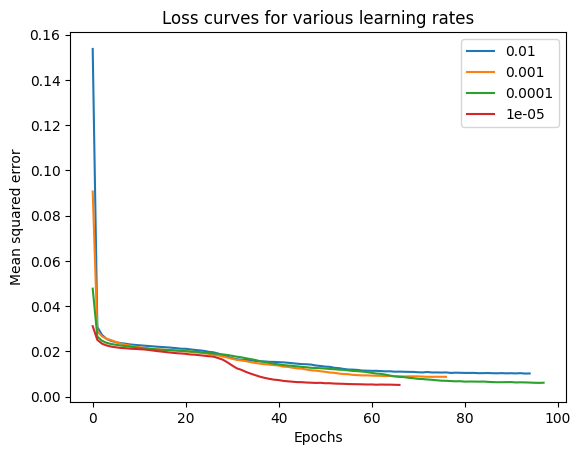

In [90]:
for lc in loss_curves:
    plt.plot(lc[1], label=lc[0])
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.title("Loss curves for various learning rates")
plt.legend()

In [146]:
new_mlp_alpha_tuned = MLPRegressor(hidden_layer_sizes=(15, 15, 15, 15, 15, 15), alpha=1e-5, max_iter=200, learning_rate="constant")
new_mlp_alpha_tuned.fit(X_train_scaled, y_train)
test_score_mlp_tuned = new_mlp_alpha_tuned.score(X_train_scaled, y_train)
train_score_mlp_tuned = new_mlp_alpha_tuned.score(X_test_scaled, y_test)


print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_score_mlp_tuned, test_score_mlp_tuned))

Train Accuracy: 0.86, Test Accuracy: 0.86


## Random Forest

Try random forest model with 1 through 100 trees

In [94]:
rfr_mses = []
for n in range(1,101):
    rfr = RandomForestRegressor(n_estimators = n)
    rfr.fit(X_train, y_train)
    rfr_mses.append(mean_squared_error(y_test, rfr.predict(X_test)))
    print(f"done with {n}")


done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done with 13
done with 14
done with 15
done with 16
done with 17
done with 18
done with 19
done with 20
done with 21
done with 22
done with 23
done with 24
done with 25
done with 26
done with 27
done with 28
done with 29
done with 30
done with 31
done with 32
done with 33
done with 34
done with 35
done with 36
done with 37
done with 38
done with 39
done with 40
done with 41
done with 42
done with 43
done with 44
done with 45
done with 46
done with 47
done with 48
done with 49
done with 50
done with 51
done with 52
done with 53
done with 54
done with 55
done with 56
done with 57
done with 58
done with 59
done with 60
done with 61
done with 62
done with 63
done with 64
done with 65
done with 66
done with 67
done with 68
done with 69
done with 70
done with 71
done with 72
done with 73
done with 74
done with 75
done with 76
done with 77
done wit

Text(0, 0.5, 'MSE')

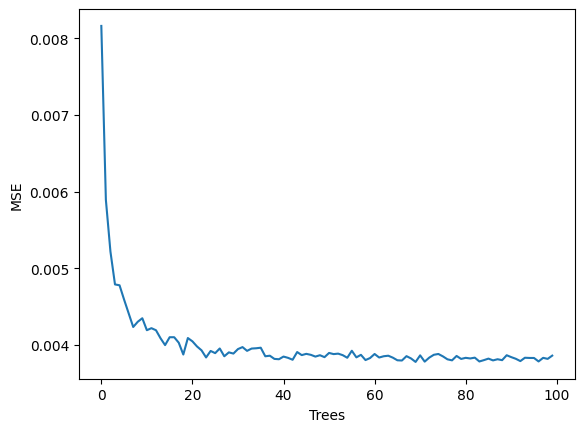

In [95]:
plt.plot(rfr_mses)
plt.xlabel("Trees")
plt.ylabel("MSE")

Testing performace of varying max depths with total max features

In [96]:
mse_max_depths = []
for d in range(1,31):
    rf_tweaked = RandomForestRegressor(n_estimators=50, max_depth=d)
    rf_tweaked.fit(X_train, y_train)
    mse_max_depths.append(mean_squared_error(y_test, rf_tweaked.predict(X_test)))
    print(f"done with {d}")

done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done with 13
done with 14
done with 15
done with 16
done with 17
done with 18
done with 19
done with 20
done with 21
done with 22
done with 23
done with 24
done with 25
done with 26
done with 27
done with 28
done with 29
done with 30


Testing performace of varying max depths with sqrt max features

In [97]:
mse_max_depths_sqrt = []
for d in range(1,31):
    rf_tweaked = RandomForestRegressor(n_estimators=50, max_depth=d, max_features="sqrt")
    rf_tweaked.fit(X_train, y_train)
    mse_max_depths_sqrt.append(mean_squared_error(y_test, rf_tweaked.predict(X_test)))
    print(f"done with {d}")

done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done with 13
done with 14
done with 15
done with 16
done with 17
done with 18
done with 19
done with 20
done with 21
done with 22
done with 23
done with 24
done with 25
done with 26
done with 27
done with 28
done with 29
done with 30


Testing performace of varying max depths with log2 max features

In [98]:
mse_max_depths_log2 = []
for d in range(1,31):
    rf_tweaked = RandomForestRegressor(n_estimators=50, max_depth=d, max_features="log2")
    rf_tweaked.fit(X_train, y_train)
    mse_max_depths_log2.append(mean_squared_error(y_test, rf_tweaked.predict(X_test)))
    print(f"done with {d}")

done with 1
done with 2
done with 3
done with 4
done with 5
done with 6
done with 7
done with 8
done with 9
done with 10
done with 11
done with 12
done with 13
done with 14
done with 15
done with 16
done with 17
done with 18
done with 19
done with 20
done with 21
done with 22
done with 23
done with 24
done with 25
done with 26
done with 27
done with 28
done with 29
done with 30


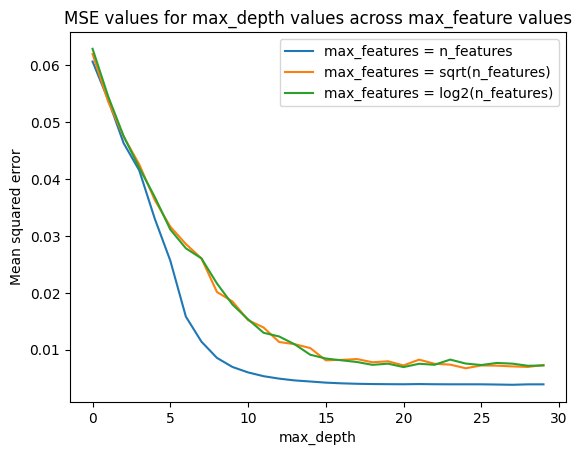

In [99]:
plt.plot(mse_max_depths, label="max_features = n_features")
plt.plot(mse_max_depths_sqrt, label="max_features = sqrt(n_features)")
plt.plot(mse_max_depths_log2, label="max_features = log2(n_features)")
plt.xlabel("max_depth")
plt.ylabel("Mean squared error")
plt.title("MSE values for max_depth values across max_feature values")
plt.legend()

Create final model with optimal hyperparameters 

In [100]:
rf_final = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=1.0)
rf_final.fit(X_train, y_train)
test_score_rf_tuned = rf_final.score(X_train, y_train)
train_score_rf_tuned = rf_final.score(X_test, y_test)


print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_score_rf_tuned, test_score_rf_tuned))

Train Accuracy: 0.94, Test Accuracy: 0.98


Finding importances of each feature in the best found RF model

Text(0.5, 1.0, 'RF feature importances')

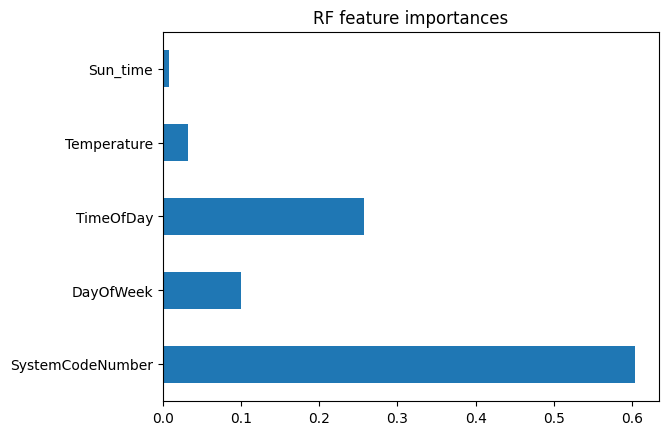

In [108]:
global_importances = pd.Series(rf_final.feature_importances_, index=X_train.columns)
global_importances.plot.barh()
plt.title("RF feature importances")

## Models without weather data

In [124]:
df_simple = df.drop(["Sun_time", "Temperature"], axis=1)

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(df_simple.iloc[:,:-1], df.iloc[:,-1:])
y_train_simple = y_train_simple.values.ravel()
y_test_simple = y_test_simple.values.ravel()

scaler_simple = StandardScaler()
X_train_scaled_simple = scaler_simple.fit_transform(X_train_simple)
X_test_scaled_simple = scaler_simple.fit_transform(X_test_simple)

df_simple

,SystemCodeNumber,DayOfWeek,TimeOfDay,OccupancyRate
0,0,1,28782.0,0.105719
1,0,1,30342.0,0.110919
2,0,1,32382.0,0.138648
3,0,1,34366.0,0.185442
4,0,1,35988.0,0.259965
...,...,...,...,...
35712,29,0,52233.0,0.790104
35713,29,0,54214.0,0.774479
35714,29,0,55773.0,0.745833
35715,29,0,57815.0,0.688021


Neural Network

In [125]:
mlp_simple = MLPRegressor(hidden_layer_sizes=(15, 15, 15, 15, 15, 15), alpha=1e-5, max_iter=200, learning_rate="constant")
mlp_simple.fit(X_train_scaled_simple, y_train_simple)
test_score_mlp_simple = mlp_simple.score(X_train_scaled_simple, y_train_simple)
train_score_mlp_simple = mlp_simple.score(X_test_scaled_simple, y_test_simple)


print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_score_mlp_simple, test_score_mlp_simple))

Train Accuracy: 0.83, Test Accuracy: 0.84


Random Forest

In [126]:
rf_simple = RandomForestRegressor(n_estimators=50, max_depth=15, max_features=1.0)
rf_simple.fit(X_train_simple, y_train_simple)
test_score_rf_simple = rf_simple.score(X_train_simple, y_train_simple)
train_score_rf_simple= rf_simple.score(X_test_simple, y_test_simple)


print("Train Accuracy: {:.2f}, Test Accuracy: {:.2f}".format(train_score_rf_simple, test_score_rf_simple))

Train Accuracy: 0.90, Test Accuracy: 0.96


Plot differences between weather and no weather results

<Axes: xlabel='Model + Data', ylabel='Accuracy'>

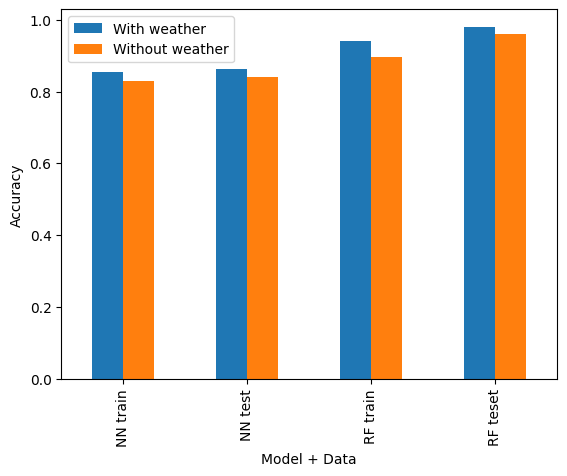

In [154]:
df_scores = pd.DataFrame([
    ["NN train", train_score_mlp_tuned, train_score_mlp_simple],
    ["NN test", test_score_mlp_tuned, test_score_mlp_simple],
    ["RF train", train_score_rf_tuned, train_score_rf_simple],
    ["RF teset", test_score_rf_tuned, test_score_rf_simple]
], columns=["Model + Data", "With weather", "Without weather"])
df_scores.plot(x="Model + Data",
        ylabel="Accuracy",
        kind='bar', 
        stacked=False) 